#Introduccion
En este ejecicio se implementaron dos filtros de color a una imagen, implementados por GPU y CPU, en los que se puede apreciar de forma muy notoria las diferencias en los tiempos que toma la ejecucion de dicho algoritmo.

#Armado del ambiente

In [ ]:
#@title #Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://upload.wikimedia.org/wikipedia/commons/4/47/VU-Banana-1000x1000.png" #@param {type:"string"}

#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true -O imagen.jpg

# TODO: Mejorar informaciòn y resutlado de ejecución. 
!wget {url_imagen} -O imagen.jpg

--2021-07-04 01:31:17--  https://upload.wikimedia.org/wikipedia/commons/4/47/VU-Banana-1000x1000.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186687 (182K) [image/png]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>] 182.31K  --.-KB/s    in 0.06s   

2021-07-04 01:31:17 (2.95 MB/s) - ‘imagen.jpg’ saved [186687/186687]



In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.7MB 7.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 71kB 11.0MB/s 
     |████████████████████████████████| 81kB 12.8MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627583 sha256=2cb682bd43bb077784102d60c121798ec53c03a048e244def01eb1267abd4815
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.7-py2.py3-none-any.whl size=60644 sha256=5a64af814c1b0e3bbb9889b1a4433163fd6795a929c59e476ab18db767ea15fa
  Stored in directory: /root/.cache/pip/wheels/a0/b5/e5/e65d25997fd77729b9aa214645add18688483e48bbcbab6ffc
Successfully built pytools


#Desarrollo

#Filtro sepia por GPU

Imagen del filtro: imagen.jpg -RGB- [1000, 1000]
Thread: [ 16 , 19  ], Bloque : [ 63 , 53 ]
Total de Thread: [ 1008 , 1007  ]  =  1015056
Tiempo TOTAL:  1394.811 [ms]
Tiempo GPU  :  1.764 [ms]


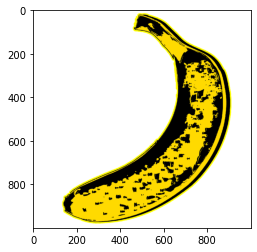

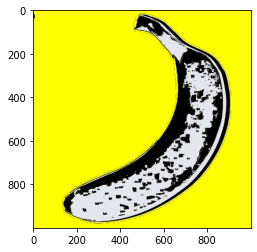

In [ ]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# summarize some details about the image 
img_alto, img_ancho = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_R_cpu = numpy.empty_like( img_O_cpu)
# img_R_cpu = numpy.empty_like( img_O_cpu)
# img_R_cpu=img_R_cpu_[0:10000 ,0:1000]


# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )
# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, char *img_O, char *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  float Rsepia = 0.0;
  float Gsepia = 0.0;
  float Bsepia = 0.0;


  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto)
  {
    // Calculo el color gris para el pixel a partir de los componentes.
    Rsepia = (float)img_O[(idx+(idy*ancho))*3    ]*0.393 + (float)img_O[((idx+(idy*ancho))*3)+1]*0.769 +(float)img_O[((idx+(idy*ancho))*3)+2]*0.189;  // Componente Rojo del pixel 
    if(Rsepia>255){ Rsepia=255;}
     
    Gsepia =(float)img_O[(idx+(idy*ancho))*3    ]*0.349 + (float)img_O[((idx+(idy*ancho))*3)+1]*0.686+(float)img_O[((idx+(idy*ancho))*3)+2]*0.168; // Componente Verde del pixel.
      if(Rsepia>255){Gsepia=255;}
      
    Bsepia =(float)img_O[(idx+(idy*ancho))*3    ]*0.272 + (float)img_O[((idx+(idy*ancho))*3)+1]*0.534+(float)img_O[((idx+(idy*ancho))*3)+2]*0.131;;  // Componente Azul del pixel.
     if(Gsepia>255){Gsepia=255;}
      
    // Escribo el color del pixel.
    img_R[(idx+(idy*ancho))*3  ] = (char) Rsepia;
    img_R[(idx+(idy*ancho))*3+1] = (char) Gsepia;
    img_R[(idx+(idy*ancho))*3+2] = (char) Bsepia;
  }
  else
  {
    img_R[(idx+(idy*ancho))*3  ] = (char) 0;
    img_R[(idx+(idy*ancho))*3+1] = (char) 0;
    img_R[(idx+(idy*ancho))*3+2] = (char) 0;
  }
}
""") 

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )

Implementacion por CPU

Imagen del filtro: imagen.jpg -RGB- [1000, 1000]
Tiempo de conversión de imagen: 20318.448 [ms]
Tiempo Total: 20386.743 [ms]


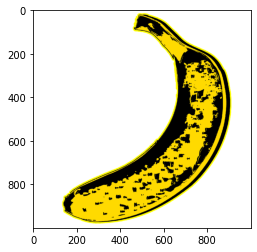

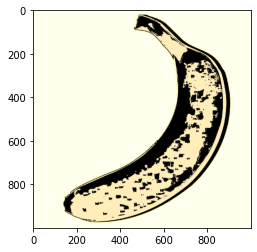

In [ ]:
%matplotlib inline
from datetime import datetime

tiempo_total = datetime.now()

import  matplotlib.pyplot as plt
import numpy
from PIL import Image 

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------


img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# Optengo las proporsiones de la imagen. 
img_alto, img_ancho = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array.
img_pic_cpu = numpy.asarray(image)

# Genero el array resultado (3 pixeles usa RGB * (el tamaño del array)).
img_picR_cpu = numpy.empty_like( img_pic_cpu)

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

plt.figure()
imgplot=plt.imshow( img_pic_cpu )

tiempo_img = datetime.now()

# Convierto la imagen a escala de grises
for y  in range( 0, img_alto ):
  for x in range( 0, img_ancho ):
#    print( x, y, img_pic_cpu[x][y] )
    pixel_R, pixel_G, pixel_B = img_pic_cpu[x][y]
    Rsepia=(0.393*pixel_R+0.769*pixel_G+0.189*pixel_B)
    if(Rsepia>255):
      Rsepia=255
    Gsepia=(0.349*pixel_R+0.686*pixel_G+0.168*pixel_B)
    if(Rsepia>255):
      Gsepia=255
    Bsepia=(0.272*pixel_R+0.534*pixel_G+0.131*pixel_B)
    if(Gsepia>255):
      Gsepia=255
    img_picR_cpu[x][y] = [Rsepia ,Gsepia , Bsepia]

tiempo_img = datetime.now() - tiempo_img

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot = plt.imshow( img_picR_cpu )

tiempo_total = datetime.now() - tiempo_total

print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img   ), "[ms]" )
print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total ), "[ms]" )

#Ejercicio 2b: Filtro negativo por GPU

Imagen del filtro: imagen.jpg -RGB- [1000, 1000]
Thread: [ 16 , 19  ], Bloque : [ 63 , 53 ]
Total de Thread: [ 1008 , 1007  ]  =  1015056
Tiempo TOTAL:  347.508 [ms]
Tiempo GPU  :  0.222 [ms]


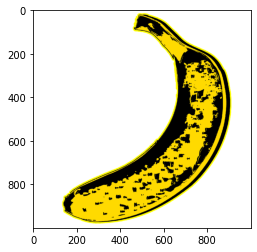

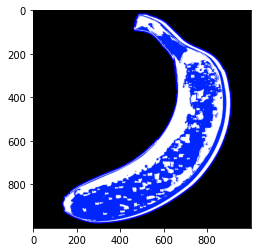

In [ ]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# summarize some details about the image 
img_alto, img_ancho = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_R_cpu = numpy.empty_like( img_O_cpu)
# img_R_cpu = numpy.empty_like( img_O_cpu)
# img_R_cpu=img_R_cpu_[0:10000 ,0:1000]


# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )
# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, char *img_O, char *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  float Rsepia = 0.0;
  float Gsepia = 0.0;
  float Bsepia = 0.0;


  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto)
  {
    // Calculo el color gris para el pixel a partir de los componentes.
    Rsepia = (float)255-img_O[(idx+(idy*ancho))*3    ];
     
    Gsepia =(float)255-img_O[(idx+(idy*ancho))*3+1    ];
      
    Bsepia =(float)255-img_O[(idx+(idy*ancho))*3+2    ];
      
    // Escribo el color del pixel.
    img_R[(idx+(idy*ancho))*3  ] = (char) Rsepia;
    img_R[(idx+(idy*ancho))*3+1] = (char) Gsepia;
    img_R[(idx+(idy*ancho))*3+2] = (char) Bsepia;
  }
  else
  {
    img_R[(idx+(idy*ancho))*3  ] = (char) 0;
    img_R[(idx+(idy*ancho))*3+1] = (char) 0;
    img_R[(idx+(idy*ancho))*3+2] = (char) 0;
  }
}
""") 

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )

Implementacion por CPU

Imagen del filtro: imagen.jpg -RGB- [1000, 1000]
Tiempo de conversión de imagen: 8897.688 [ms]
Tiempo Total: 8971.94 [ms]


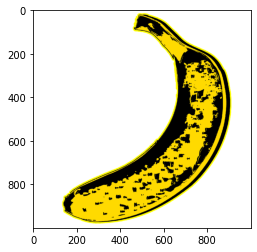

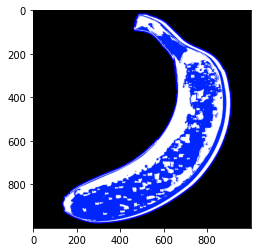

In [ ]:
%matplotlib inline
from datetime import datetime

tiempo_total = datetime.now()

import  matplotlib.pyplot as plt
import numpy
from PIL import Image 

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------


img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# Optengo las proporsiones de la imagen. 
img_alto, img_ancho = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array.
img_pic_cpu = numpy.asarray(image)

# Genero el array resultado (3 pixeles usa RGB * (el tamaño del array)).
img_picR_cpu = numpy.empty_like( img_pic_cpu)

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

plt.figure()
imgplot=plt.imshow( img_pic_cpu )

tiempo_img = datetime.now()

# Convierto la imagen a escala de grises
for y  in range( 0, img_alto ):
  for x in range( 0, img_ancho ):
#    print( x, y, img_pic_cpu[x][y] )
    pixel_R, pixel_G, pixel_B = img_pic_cpu[x][y]
    img_picR_cpu[x][y] = [(255-pixel_R), (255-pixel_G), (255-pixel_B)]

tiempo_img = datetime.now() - tiempo_img

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot = plt.imshow( img_picR_cpu )

tiempo_total = datetime.now() - tiempo_total

print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img   ), "[ms]" )
print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total ), "[ms]" )

#Metricas
Analizando las resultados de tiempo obtenidos tras varias ejecuciones de los filtros se vio que:
  El filtro sepia ejecutado por CPU toma en promedio 20seg, ejecutad0 por GPU toma en promedio <1ms
  El Filtro negativo ejecutado por CPU toma en promedio 10seg, ejecutado por GPU toma en promedio <0.5ms

#Conclucion
Comparando los timepos de jecucion de los filtros que se desarrollaron en este cuaderno, se puede tener una clara perspectiva de los beneficios que tiene la computacion de altas prestaciones para el procesamiento de imagenes, siendo unas 20.000 veces mas rapido en la ejecucion de los algoritmos desarrollados.

#Bibliografia
https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%202%20-%20Imagen%20-%20GPU.ipynb